In [185]:
from auto_mm_bench.datasets import dataset_registry
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import shap
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from transformers.pipelines.pt_utils import KeyDataset
# import concatenate_datasets, load_from_disk
from datasets import concatenate_datasets, load_from_disk
import os

# Models

## Tab

In [67]:
dataset_name = 'imdb_genre_prediction'

train_dataset = dataset_registry.create(dataset_name, 'train')
test_dataset = dataset_registry.create(dataset_name, 'test')
train_dataset.data

label_cols = train_dataset.label_columns
tab_cols = ['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']
text_cols = ['Description']

ds = load_dataset('james-burton/imdb_genre_prediction2')

train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()
val_df = ds['validation'].to_pandas()
X_train_tab = train_df[tab_cols]
y_train = train_df[label_cols]
X_test_tab = test_df[tab_cols]
y_test = test_df[label_cols]
X_val_tab = val_df[tab_cols]
y_val = val_df[label_cols]

tab_model = lgb.LGBMClassifier(random_state=42)
tab_model.fit(X_train_tab,y_train)
y_pred = tab_model.predict(X_test_tab)
y_pred_probs = tab_model.predict_proba(X_test_tab)
y_pred_val = tab_model.predict(X_val_tab)
y_pred_probs_val = tab_model.predict_proba(X_val_tab)


print('Accuracy: ', np.mean(y_test.values.flatten() == y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred_probs[:,1]))
print('Accuracy: ', np.mean(y_val.values.flatten() == y_pred_val))
print('ROC AUC: ', roc_auc_score(y_val, y_pred_probs_val[:,1]))

Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 1628.86it/s]


Dataset parquet downloaded and prepared to /home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 779.95it/s]
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy:  0.78
ROC AUC:  0.8342508257431689
Accuracy:  0.7583333333333333
ROC AUC:  0.828420467185762


## Text

In [4]:
text_model = AutoModelForSequenceClassification.from_pretrained('../models/imdb_genre/frosty-night-14/checkpoint-22', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    
# Tokenize the dataset
def encode(examples):
    return {
        "labels": np.array([examples['Genre_is_Drama']]),
                **tokenizer(examples['Description'], truncation=True, padding="max_length")}
ds = ds.map(encode)
trainer = Trainer(model=text_model)
text_preds = F.softmax(torch.tensor(trainer.predict(ds['test']).predictions), dim=1).numpy()

print('Accuracy: ', np.mean(np.argmax(text_preds, axis=1) == y_test.values.flatten()))
print('ROC AUC: ', roc_auc_score(y_test.values.flatten(), text_preds[:,1]))

Loading cached processed dataset at /home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-bbdb7891ad59dbdb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-7cdb3dce014d11c7.arrow
Loading cached processed dataset at /home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-bbdb7891ad59dbdb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-c6b61b079a5eb143.arrow
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes). If Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes) are not expected by `DistilBertForSequenceClassification.forward`,  you can safely i

Accuracy:  0.7
ROC AUC:  0.8112301070963868


In [5]:
text_pipeline = pipeline('text-classification', model=text_model, tokenizer=tokenizer, device=0)

# text_test_preds = np.array([format_text_pred(pred) for pred in 
text_pipeline(list(ds['test']['Description']))

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_1', 'score': 0.8335848450660706},
 {'label': 'LABEL_0', 'score': 0.8803748488426208},
 {'label': 'LABEL_1', 'score': 0.8357711434364319},
 {'label': 'LABEL_1', 'score': 0.9042026400566101},
 {'label': 'LABEL_0', 'score': 0.5526532530784607},
 {'label': 'LABEL_0', 'score': 0.6040405035018921},
 {'label': 'LABEL_1', 'score': 0.8153607845306396},
 {'label': 'LABEL_1', 'score': 0.7589836716651917},
 {'label': 'LABEL_0', 'score': 0.8391640782356262},
 {'label': 'LABEL_0', 'score': 0.7054075002670288},
 {'label': 'LABEL_1', 'score': 0.8175597190856934},
 {'label': 'LABEL_0', 'score': 0.9203829765319824},
 {'label': 'LABEL_0', 'score': 0.7813015580177307},
 {'label': 'LABEL_1', 'score': 0.6700841784477234},
 {'label': 'LABEL_0', 'score': 0.8996774554252625},
 {'label': 'LABEL_0', 'score': 0.6677643656730652},
 {'label': 'LABEL_1', 'score': 0.63693767786026},
 {'label': 'LABEL_0', 'score': 0.8531956672668457},
 {'label': 'LABEL_1', 'score': 0.8877248167991638},
 {'label': 'LA

## Weighted Ensemble - Even weighting

In [6]:
tab_weight = 0.5

text_preds = trainer.predict(ds['test']).predictions
tab_preds = tab_model.predict_proba(X_test_tab)
ensemble_preds = tab_weight * tab_preds + (1 - tab_weight) * text_preds
print('Accuracy: ', np.mean(np.argmax(ensemble_preds, axis=1) == y_test.values.flatten()))
print('ROC AUC: ', roc_auc_score(y_test.values.flatten(), ensemble_preds[:,1]))

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes). If Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes) are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 200
  Batch size = 8
100%|██████████| 25/25 [00:01<00:00, 19.86it/s]

Accuracy:  0.77
ROC AUC:  0.8488639775798219


## Weighted Ensemble - Grid search for best weight

In [7]:
# Text
text_preds = F.softmax(torch.tensor(trainer.predict(ds['validation']).predictions), dim=1).numpy()

# Tab
val_df = ds['validation'].to_pandas()
X_val = val_df[tab_cols]
y_val = val_df[label_cols]
tab_preds = tab_model.predict_proba(X_val)


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes). If Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes) are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 120
  Batch size = 8
100%|██████████| 15/15 [00:00<00:00, 20.13it/s]


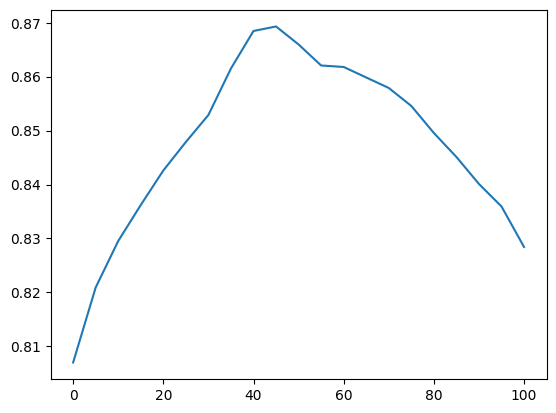

Best ROC AUC:  0.8692992213570634  at  0.45


In [8]:

roc_results = {}
acc_results = {}
for i in range(0,101,5):
    tab_prop = i/100
    text_prop = 1 - tab_prop
    preds = tab_prop * tab_preds + text_prop * text_preds
    roc_results[i] = roc_auc_score(y_val.values.flatten(), preds[:,1])
    acc_results[i] = np.mean(np.argmax(preds, axis=1) == y_val.values.flatten())

best_roc_weight = list(roc_results.keys())[list(roc_results.values()).index(max(roc_results.values()))]/100
plt.plot(list(roc_results.keys()), list(roc_results.values()))
plt.show()
# plt.plot(list(acc_results.keys()), list(acc_results.values()))
# plt.show()
print('Best ROC AUC: ', max(roc_results.values()), ' at ', best_roc_weight)

In [9]:
text_preds = trainer.predict(ds['test']).predictions
tab_preds = tab_model.predict_proba(X_test_tab)
ensemble_preds = best_roc_weight * tab_preds + (1 - best_roc_weight) * text_preds
print('Accuracy: ', np.mean(np.argmax(ensemble_preds, axis=1) == y_test.values.flatten()))
print('ROC AUC: ', roc_auc_score(y_test.values.flatten(), ensemble_preds[:,1]))

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes). If Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes) are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 200
  Batch size = 8
100%|██████████| 25/25 [00:01<00:00, 19.76it/s]

Accuracy:  0.755
ROC AUC:  0.8460614553097787


## Training a stack ensemble

[Good link on stack ensemble](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/stacked-ensembles.html)

In [10]:
text_pipeline = pipeline('text-classification', model=text_model, tokenizer=tokenizer, device=0)

# Training set is the preditions from the tabular and text models
text_val_preds = F.softmax(torch.tensor(trainer.predict(ds['validation']).predictions), dim=1).numpy()
tab_val_preds = tab_model.predict_proba(X_val_tab)
text_test_preds = F.softmax(torch.tensor(trainer.predict(ds['test']).predictions), dim=1).numpy()
tab_test_preds = tab_model.predict_proba(X_test_tab)
text_train_preds = F.softmax(torch.tensor(trainer.predict(ds['train']).predictions), dim=1).numpy()
tab_train_preds = tab_model.predict_proba(X_train_tab)


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes). If Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes) are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 120
  Batch size = 8
100%|██████████| 15/15 [00:00<00:00, 20.53it/s]
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, Rating, Director, Rank, Runtime (Minutes). If Title, Votes, Year, Metascore, Description, Actors, Revenue (Millions), Genre_is_Drama, R

In [11]:
# add text and tabular predictions to the val_df
stack_val_df = val_df[tab_cols]
stack_val_df['tab_preds'] = tab_val_preds[:,1]
stack_val_df['text_preds'] = text_val_preds[:,1]
stack_test_df = test_df[tab_cols]
stack_test_df['tab_preds'] = tab_test_preds[:,1]
stack_test_df['text_preds'] = text_test_preds[:,1]
# stack_train_df = train_df[tab_cols]
# stack_train_df['tab_preds'] = tab_train_preds[:,1]
# stack_train_df['text_preds'] = text_train_preds[:,1]

stack_model = lgb.LGBMClassifier(random_state=42)
stack_model.fit(stack_val_df, y_val)
# stack_model.fit(stack_train_df, y_train)

stack_pred = stack_model.predict_proba(stack_test_df)
print('Accuracy: ', np.mean(y_test.values.flatten() == np.argmax(stack_pred, axis=1)))
print('ROC AUC: ', roc_auc_score(y_test, stack_pred[:,1]))

stack_pred_val = stack_model.predict_proba(stack_val_df)
print('Accuracy: ', np.mean(y_val.values.flatten() == np.argmax(stack_pred_val, axis=1)))
print('ROC AUC: ', roc_auc_score(y_val, stack_pred_val[:,1]))

# y_pred = tab_model.predict(X_test_tab)
# y_pred_probs = tab_model.predict_proba(X_test_tab)
# print('Accuracy: ', np.mean(y_test.values.flatten() == y_pred))
# print('ROC AUC: ', roc_auc_score(y_test, y_pred_probs[:,1]))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy:  0.77
ROC AUC:  0.8549694725252728
Accuracy:  0.9666666666666667
ROC AUC:  0.9974972191323692


## All as text

In [74]:
all_text_model = AutoModelForSequenceClassification.from_pretrained('../models/imdb_genre_text/eager-lake-5/checkpoint-44', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    
# Tokenize the dataset
def encode(examples):
    return {
        "labels": np.array([examples['Genre_is_Drama']]),
                **tokenizer(examples['text'], truncation=True, padding="max_length")}
all_text_ds = load_dataset('james-burton/imdb_genre_prediction_all_text')
all_text_ds = all_text_ds.map(encode)
all_text_trainer = Trainer(model=all_text_model)
all_text_preds = F.softmax(torch.tensor(all_text_trainer.predict(all_text_ds['test']).predictions), dim=1).numpy()

print('Accuracy: ', np.mean(np.argmax(all_text_preds, axis=1) == y_test.values.flatten()))
print('ROC AUC: ', roc_auc_score(y_test.values.flatten(), all_text_preds[:,1]))

loading configuration file ../models/imdb_genre_text/eager-lake-5/checkpoint-44/config.json
Model config DistilBertConfig {
  "_name_or_path": "../models/imdb_genre_text/eager-lake-5/checkpoint-44",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file ../models/imdb_genre_text/eager-lake-5/checkpoint-44/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassi

Accuracy:  0.745
ROC AUC:  0.80762686417776


# SHAP

## Tab

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


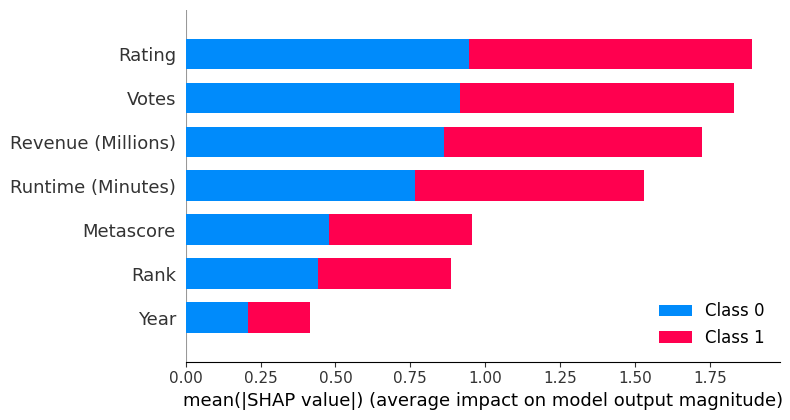

In [12]:
tab_explainer = shap.TreeExplainer(tab_model)
tab_shap_values = tab_explainer.shap_values(X_test_tab)
shap.summary_plot(tab_shap_values, X_test_tab, plot_type="bar")

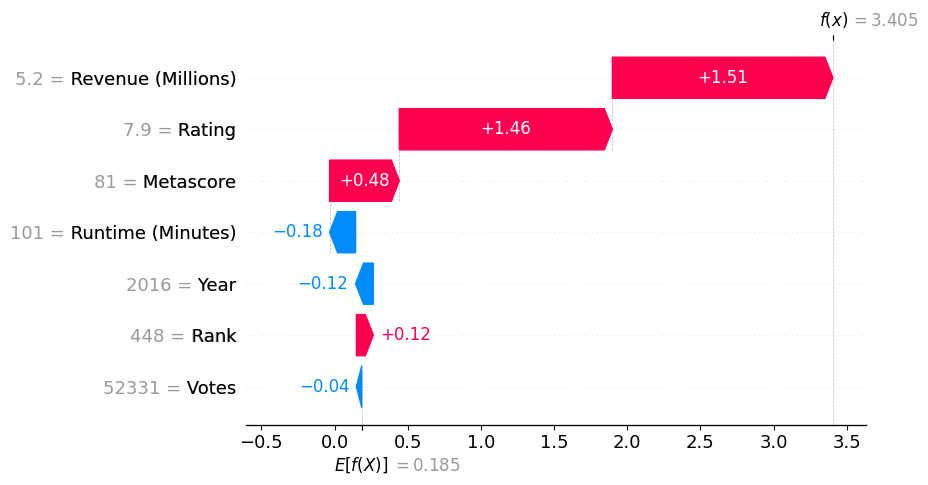

In [13]:
# # Select the shap values for the sixth instance
instance_idx = 6

shap.waterfall_plot(shap.Explanation(values=tab_shap_values[1][instance_idx], base_values=tab_explainer.expected_value[1], data=X_test_tab.iloc[instance_idx]))

## Text

In [229]:
ds_test_text = ds['test'].rename_columns({'Description': 'text', 'Genre_is_Drama': 'label'})
    # keep only the text and label columns
ds_test_text = ds_test_text.select_columns(['text', 'label'])


In [268]:
text_model = AutoModelForSequenceClassification.from_pretrained(
    "../models/imdb_genre/frosty-night-14/checkpoint-22", num_labels=2
)
# text_model = torch.compile(text_model)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_pipeline = pipeline('text-classification', model=text_model, tokenizer=tokenizer, device="cuda:0")

def format_text_pred(pred):
    if pred['label'] == 'LABEL_1':
        return np.array([1-pred['score'], pred['score']])
    else:
        return np.array([pred['score'], 1-pred['score']])

# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = text_model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    return scores

def text_pred_fn(examples):
    dataset = Dataset.from_dict({'text': examples})
    # put the dataset on the GPU
    
    preds = [out for out in text_pipeline(KeyDataset(dataset, "text"), batch_size=64)]
    preds = np.array([format_text_pred(pred) for pred in preds])
    return preds

text_explainer = shap.Explainer(text_pred_fn, tokenizer)
# text_explainer = shap.Explainer(f, tokenizer)
text_shap_values = text_explainer(ds_test_text[:], fixed_context=1, batch_size=64)

loading configuration file ../models/imdb_genre/frosty-night-14/checkpoint-22/config.json
Model config DistilBertConfig {
  "_name_or_path": "../models/imdb_genre/frosty-night-14/checkpoint-22",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file ../models/imdb_genre/frosty-night-14/checkpoint-22/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassificati

In [281]:
shap.plots.text(text_shap_values[0])
shap.plots.text(text_shap_values[134])
shap.plots.text(text_shap_values[1])

If we want to get an overall picture of how important the text is to the decision then how does it work if we treat the text like a single block?

If it is just a simple weighted ensemble then it will not be too useful as the the masked/hidden text, which in shap I'm pretty sure is just the word (or in our case entire text) removed, will produce the same output from the transformer part every time. Actually we can't do it like that as replacing the word with a blank makes sense but replacing the entire text feels strange. How does it work for tabular features? 

[Kernel shap consists of five steps](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap):
* Sample coalitions z′k ∈ {0,1}M, k ∈ {1, ..., K} where 1 represents the presence of a feature in the coalition and 0 represents the absence.
* Obtain the model prediction for each z′k by converting it to the original feature space and applying the model ^f: ^f(hx(z′k)).
* Compute the SHAP kernel weight for each z′k.
* Fit a weighted linear model using the computed weights.
* Return the Shapley values ϕk, which are the coefficients obtained from the linear model.

If the text column was just another tabular column... well actually if we treat it like a categorical column then we could say what would the output be with it removed ie completely blank. 

For example if blank makes the text model predict 0.2
example makes text model predict 0.8
and it was a 50/50 split in the training data then the shap value for text would be 0.5 * (0.8 - 0.2) = 0.3

For continuous variables SHAP uses a weighted average of other observations in a background dataset. The weights are determined by a kernel function that measures how similar an observation is to the original one.

Still need to think about how it all fits in, but I can pre-calculate the similarity to other data points before hand using a kernel function such as cosine similarity. (A kernel function is simply a  function is used to measure the similarity between two vectors.) I can pre-calculate the similarity but I would still need to calculate the model prediction for each z′k by converting it to the original feature space and applying the model ^f: ^f(hx(z′k)).

It should be a linear transformation between the explanations of the tab model and the explanations of the whole model, probably the weight of each of the branches multiplied together.

For when it is not a weighted combination of the two modalities:
* Should I be able to take advantage of TreeSHAP to get the shap values for the tabular part? Not sure. Worrying about making things faster is probably premature optimisation.
* This kind of relates back to the old hierarchical stuff, I can look at just the top model and see how much it relies on the text input vs the tabular

What is the next steps?
* I want to see how the explanations change when I combine them in different ways, but in order to do so I do need to buld an implementation of SHAP where it does something like I am talking about above
* I can't just do what I was doing with the hierarchical stuff because text is not the same as a categorical variable, not for transformers anyway

Steps:
* Changes dataframe into array
* Goes over each sample in the dataset you are explaining
* In the explain function the meat seems to come if more than one feature varies, otherwise shortcuts happen to make it faster
* 

In self.run() a new dataframe is created from the new samples and then this is passed through the model to create new predictions. If I have my data here in whatever format, I think I can make the prediction in the prediction function. Therefore it is before this when the sampling and the weighting is done where I will need to make changes.

If the text was just another column, then I would 

## Joint

In [19]:
text_model = AutoModelForSequenceClassification.from_pretrained('../models/imdb_genre/frosty-night-14/checkpoint-22', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    
# Tokenize the dataset
def encode(examples):
    return {
        "labels": np.array([examples['Genre_is_Drama']]),
                **tokenizer(examples['Description'], truncation=True, padding="max_length")}
ds = ds.map(encode)



loading configuration file ../models/imdb_genre/frosty-night-14/checkpoint-22/config.json
Model config DistilBertConfig {
  "_name_or_path": "../models/imdb_genre/frosty-night-14/checkpoint-22",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file ../models/imdb_genre/frosty-night-14/checkpoint-22/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassificati

In [35]:


class Model():
    def __init__(self, text_to_pred_dict=None):
        self.text_to_pred_dict = text_to_pred_dict
        self.text_pred_len = 0
        
    def predict_both(self, examples, text_weight=0.5, load_from_cache=True):
        tab_examples = examples[:,:-1]
        tab_preds = tab_model.predict_proba(tab_examples)
        text_examples = examples[:,-1]
        
        desc_dict = {}
        for i, desc in tqdm(enumerate(text_examples)):
            if desc not in desc_dict:
                desc_dict[desc] = [i]
            else:
                desc_dict[desc].append(i)
        
        if load_from_cache:
            text_preds = np.array([self.text_to_pred_dict[desc] for desc in desc_dict.keys()])    
            
        else:
            text_preds = text_pipeline(list(desc_dict.keys()))
            text_preds = np.array([format_text_pred(pred) for pred in text_preds])
                            
        
        expanded_text_preds = np.zeros((len(text_examples), 2))
        for i, (desc, idxs) in enumerate(desc_dict.items()):
            expanded_text_preds[idxs] = text_preds[i]
        
        # Combine the predictions, multiplying the text and predictions by 0.5
        preds = text_weight * expanded_text_preds + (1-text_weight) * tab_preds
        return preds

class StackModel():
    def __init__(self, text_to_pred_dict=None):
        self.text_to_pred_dict = text_to_pred_dict
        self.text_pred_len = 0
        
    def predict_both(self, examples, load_from_cache=True):
        tab_examples = examples[:,:-1]
        tab_preds = tab_model.predict_proba(tab_examples)
        text_examples = examples[:,-1]
        
        desc_dict = {}
        for i, desc in tqdm(enumerate(text_examples)):
            if desc not in desc_dict:
                desc_dict[desc] = [i]
            else:
                desc_dict[desc].append(i)
        
        if load_from_cache:
            text_preds = np.array([self.text_to_pred_dict[desc] for desc in desc_dict.keys()])    
            
        else:
            text_preds = text_pipeline(list(desc_dict.keys()))
            text_preds = np.array([format_text_pred(pred) for pred in text_preds])
                            
        
        expanded_text_preds = np.zeros((len(text_examples), 2))
        for i, (desc, idxs) in enumerate(desc_dict.items()):
            expanded_text_preds[idxs] = text_preds[i]
        
        # Stack
        stack_examples = np.hstack([tab_examples, tab_preds[:,1:], expanded_text_preds[:,1:]])
        stack_preds = stack_model.predict_proba(stack_examples)
        
        return stack_preds
    


In [69]:
X_train = train_df[tab_cols + text_cols]
X_test = test_df[tab_cols + text_cols]

As the predictions from the transformer model will always be the same for a given input, I precalculate the predictions for each of the samples in the background dataset (X_train) and the prediction dataset (X_test). This means that an explanation run through takes 100s instead of 10 mins.

In [25]:
X_test_train = pd.concat([X_train, X_test])
text_preds = text_pipeline(list(X_test_train['Description']))


text_preds = np.array([format_text_pred(pred) for pred in text_preds])
            
text_to_pred_dict = {desc: preds for desc, preds in zip(list(X_test_train['Description']), text_preds)}

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Even weighting

680it [00:00, 1133595.68it/s]
Using 680 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
1it [00:00, 8848.74it/s]00:00<?, ?it/s]
172720it [00:00, 3586905.78it/s]
1it [00:00, 9157.87it/s]00:00<02:01,  1.64it/s]
172720it [00:00, 3594380.43it/s]
1it [00:00, 9404.27it/s]00:01<01:57,  1.68it/s]
172720it [00:00, 3886127.27it/s]
1it [00:00, 9446.63it/s]00:01<01:51,  1.76it/s]
172720it [00:00, 3697953.51it/s]
1it [00:00, 2709.50it/s]00:02<01:50,  1.78it/s]
172720it [00:00, 3842287.14it/s]
1it [00:00, 7530.17it/s]00:02<01:48,  1.80it/s]
172720it [00:00, 3601850.48it/s]
1it [00:00, 9279.43it/s]00:03<01:49,  1.77it/s]
172720it [00:00, 3708839.42it/s]
1it [00:00, 10727.12it/s]0:03<01:48,  1.78it/s]
172720it [00:00, 3735248.22it/s]
1it [00:00, 9664.29it/s]00:04<01:50,  1.74it/s]
172720it [00:00, 3540002.09it/s]
1it [00:00, 8886.24it/s]00:05<01:47,  1.78it/s]
172720it [00:00, 3095408.79it/s]
1i

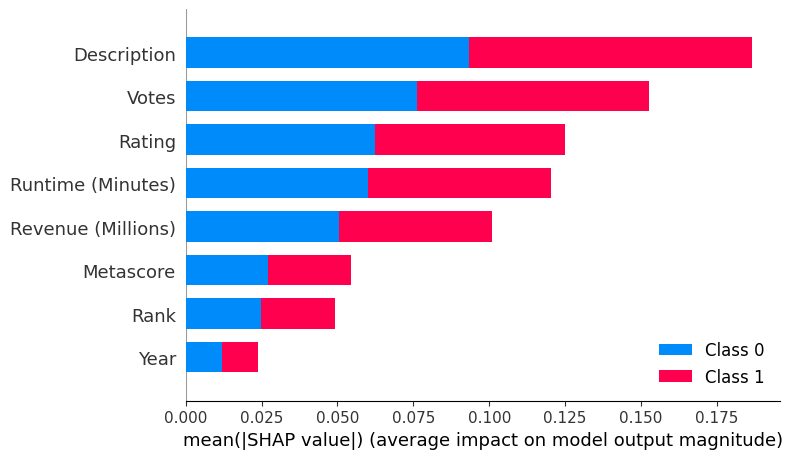

In [132]:
test_model = Model(text_to_pred_dict)

kernel_explain = shap.KernelExplainer(lambda x: test_model.predict_both(x,text_weight=0.5), X_train)
kernel_shap_values = kernel_explain.shap_values(X_test) #, nsamples=100)
shap.summary_plot(kernel_shap_values, X_test, plot_type="bar")

### Text weight: .25

680it [00:00, 1218336.92it/s]
Using 680 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
1it [00:00, 16980.99it/s]0:00<?, ?it/s]
172720it [00:00, 3705007.86it/s]
1it [00:00, 9258.95it/s]00:00<01:59,  1.66it/s]
172720it [00:00, 3469208.83it/s]
1it [00:00, 9404.27it/s]00:01<01:54,  1.72it/s]
172720it [00:00, 3432210.90it/s]
1it [00:00, 10951.19it/s]0:01<01:56,  1.69it/s]
172720it [00:00, 3564597.05it/s]
1it [00:00, 16131.94it/s]0:02<01:54,  1.71it/s]
172720it [00:00, 3794529.49it/s]
1it [00:00, 16644.06it/s]0:02<01:53,  1.72it/s]
172720it [00:00, 3863371.93it/s]
1it [00:00, 8886.24it/s]00:03<01:51,  1.73it/s]
172720it [00:00, 3706164.08it/s]
1it [00:00, 9137.92it/s]00:04<01:51,  1.73it/s]
172720it [00:00, 3682539.34it/s]
1it [00:00, 21732.15it/s]0:04<01:50,  1.74it/s]
172720it [00:00, 3709143.25it/s]
1it [00:00, 9039.45it/s]00:05<01:49,  1.74it/s]
172720it [00:00, 3643002.48it/s]
1i

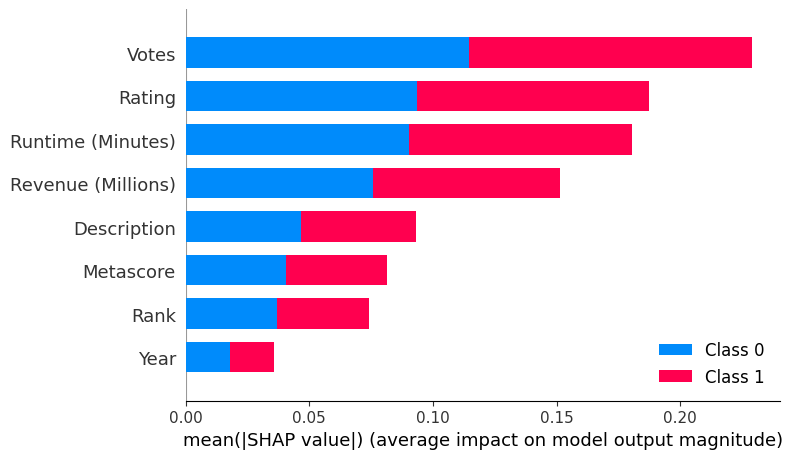

In [130]:
test_model = Model(text_to_pred_dict)

kernel_explain_25 = shap.KernelExplainer(lambda x: test_model.predict_both(x,text_weight=0.25), X_train)
kernel_shap_values_25 = kernel_explain_25.shap_values(X_test)
shap.summary_plot(kernel_shap_values_25, X_test, plot_type="bar")

### Text weight: .75

680it [00:00, 158645.38it/s]
Using 680 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
1it [00:00, 8065.97it/s]00:00<?, ?it/s]
172720it [00:00, 406183.58it/s]
1it [00:00, 6278.90it/s]04:35<15:13:22, 275.39s/it]
172720it [00:00, 406997.79it/s]
1it [00:00, 6335.81it/s]04:36<6:16:16, 114.02s/it] 
172720it [00:00, 417499.78it/s]
1it [00:00, 6364.65it/s]04:37<3:24:56, 62.42s/it] 
172720it [00:00, 422141.13it/s]
1it [00:00, 11683.30it/s]4:38<2:04:40, 38.16s/it]
172720it [00:00, 419557.20it/s]
1it [00:00, 6636.56it/s]04:39<1:20:28, 24.76s/it]
172720it [00:00, 409547.62it/s]
1it [00:00, 6413.31it/s]04:40<53:56, 16.68s/it]  
172720it [00:00, 429051.26it/s]
1it [00:00, 6492.73it/s]04:41<37:10, 11.56s/it]
172720it [00:00, 423920.44it/s]
1it [00:00, 8405.42it/s]04:42<26:14,  8.20s/it]
172720it [00:00, 426305.29it/s]
1it [00:00, 6355.01it/s]04:43<18:57,  5.96s/it]
172720it [00:00, 413379.53it

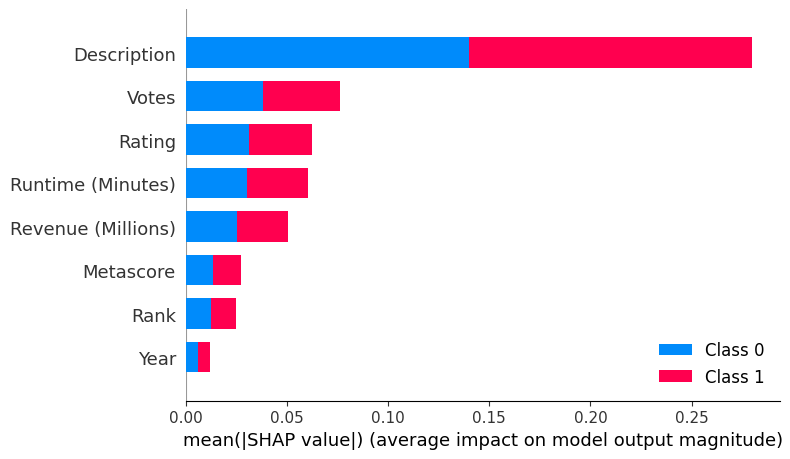

In [134]:
test_model = Model(text_to_pred_dict)

kernel_explain_75 = shap.KernelExplainer(lambda x: test_model.predict_both(x,text_weight=0.75), X_train)
kernel_shap_values_75 = kernel_explain_75.shap_values(X_test)
shap.summary_plot(kernel_shap_values_75, X_test, plot_type="bar")

## Stack Ensemble

680it [00:00, 213067.89it/s]
Using 680 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
1it [00:00, 4211.15it/s]00:00<?, ?it/s]
172720it [00:00, 398877.10it/s]
1it [00:00, 6123.07it/s]00:01<04:15,  1.28s/it]
172720it [00:00, 397890.81it/s]
1it [00:00, 5882.61it/s]00:02<04:09,  1.26s/it]
172720it [00:00, 391648.78it/s]
1it [00:00, 5269.23it/s]00:03<04:09,  1.27s/it]
172720it [00:00, 334287.22it/s]
1it [00:00, 5857.97it/s]00:05<04:13,  1.29s/it]
172720it [00:00, 375136.80it/s]
1it [00:00, 6875.91it/s]00:06<04:07,  1.27s/it]
172720it [00:00, 398816.49it/s]
1it [00:00, 5584.96it/s]00:07<04:01,  1.24s/it]
172720it [00:00, 411721.82it/s]
1it [00:00, 4223.87it/s]00:08<03:55,  1.22s/it]
172720it [00:00, 402924.76it/s]
1it [00:00, 7825.19it/s]00:09<03:51,  1.21s/it]
172720it [00:00, 368927.38it/s]
1it [00:00, 6605.20it/s]00:11<03:51,  1.21s/it]
172720it [00:00, 400795.45it/s]
1it [00:00, 8

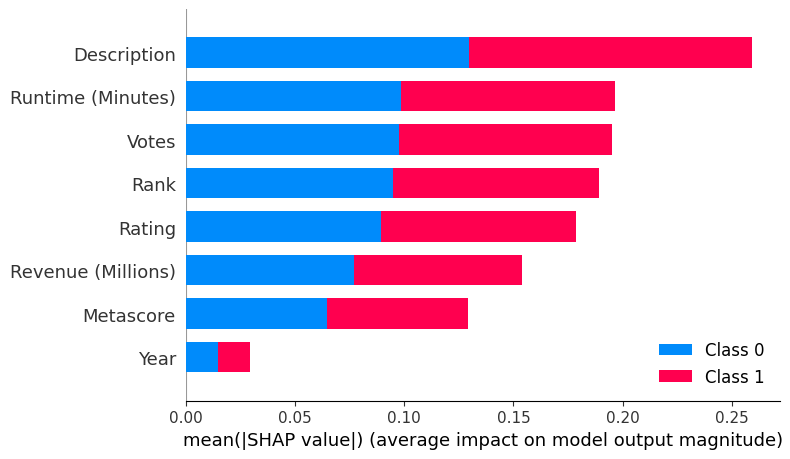

In [41]:
stack_test_model = StackModel(text_to_pred_dict)

kernel_explain_stack = shap.KernelExplainer(stack_test_model.predict_both, X_train)
kernel_shap_values_stack = kernel_explain_stack.shap_values(X_test)
shap.summary_plot(kernel_shap_values_stack, X_test, plot_type="bar")

In [123]:
len(text_to_pred_dict)

880

In [ ]:
instance_idx = 0
instance_shap_values = kernel_shap_values[1][instance_idx]

# Get the base value for the model
base_value = kernel_explain.expected_value[1]

# Generate a force plot for the sixth instance
shap.force_plot(base_value, instance_shap_values, X_test.iloc[instance_idx])

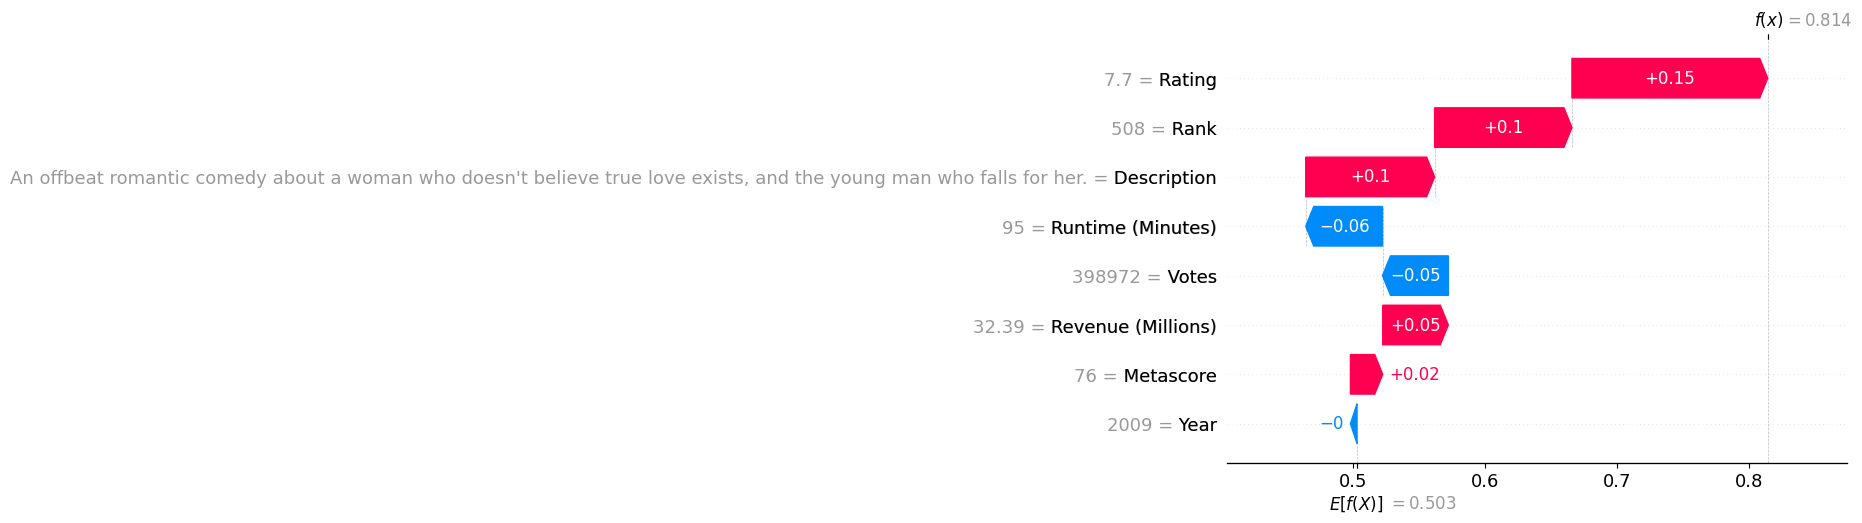

In [64]:
shap.waterfall_plot(shap.Explanation(values=kernel_shap_values[1][0], base_values=kernel_explain.expected_value[1], data=X_test.iloc[0]))

There are only 681 unique values in the text column, but I am required to run the the model on 68,000 samples 

## All as text

In [286]:
all_text_pipeline = pipeline('text-classification', model=all_text_model, tokenizer=tokenizer, device=0)
all_text_explainer = shap.Explainer(all_text_pipeline)
all_text_shap_values = all_text_explainer(list(all_text_ds['test']['text'])[:15])

Partition explainer: 16it [00:29,  2.90s/it]                        


In [283]:
all_text_pipeline = pipeline('text-classification', model=all_text_model, tokenizer=tokenizer, device=0)
all_text_explainer = shap.Explainer(all_text_pipeline, fixed_context=1)
all_text_shap_values = all_text_explainer(list(all_text_ds['test']['text'])[:15])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Partition explainer: 16it [00:11,  5.60s/it]                


In [285]:
all_text_pipeline = pipeline('text-classification', model=all_text_model, tokenizer=tokenizer, device='cuda:0')
all_text_explainer = shap.Explainer(all_text_pipeline)  #, fixed_context=True)
all_text_shap_values = all_text_explainer(list(all_text_ds['test']['text'])[:15])

Partition explainer: 16it [00:30,  2.74s/it]                        


In [61]:
shap.plots.text(all_text_shap_values[0,:,"LABEL_1"])

In [180]:
cols = ['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank', 'Description']
all_text_pipeline2 = pipeline('text-classification', model=all_text_model, tokenizer=tokenizer, device=torch.device('cuda:0'))
all_text_pipeline3 = pipeline('text-classification', model=all_text_model, tokenizer=tokenizer, device=0)

def array_to_string(array):
    return np.array(' | '.join([f'{col}: {val}' for col, val in zip(cols, array)]), dtype='<U512')

def data(dataset):
    for i in range(len(dataset)):
        yield dataset['text'][i]

class AllTextModel():
    def __init__(self, text_to_pred_dict=None):
        self.text_to_pred_dict = text_to_pred_dict
        self.text_pred_len = 0
        
    def predict_both(self, examples, load_from_cache=True):
        examples_as_strings = np.apply_along_axis(array_to_string, 1, examples)
        dataset = Dataset.from_pandas(pd.DataFrame({'text': examples_as_strings}))
        # save dataset to cache
        if len(dataset) > 1000:
            # check if folder exists
            i = 0
            while True:
                dir = 'all_text_examples_' + str(i)
                if not os.path.isdir(dir):
                    # load old dataset
                    if i == 0:
                        dataset.save_to_disk(dir)
                    else:
                        old = load_from_disk(f'all_text_examples_{i-1}')
                        new = concatenate_datasets([old, dataset])
                        # save new dataset
                        new.save_to_disk(dir)
                        break
                i += 1
                
            # delete old dataset file
            
            
            
            new.save_to_disk('all_text_examples' + str(len(new)))
        # preds = all_text_pipeline2(dataset['text'], batch_size=32)
        # preds = []
        # for d in tqdm(data(dataset)):
        #     out = all_text_pipeline2(d)[0]
        #     preds.append(out)
        preds = [out for out in all_text_pipeline3(KeyDataset(dataset, "text"), batch_size=64)] #, total=len(examples))]
        preds = np.array([format_text_pred(pred) for pred in preds])
        
        return preds
    

In [181]:
all_text_test_model = AllTextModel(text_to_pred_dict)

kernel_explain_all_text = shap.KernelExplainer(all_text_test_model.predict_both, X_train)
kernel_shap_values_all_text = kernel_explain_all_text.shap_values(X_test[:10], nsamples=10)
# shap.summary_plot(kernel_shap_values_all_text, X_test, plot_type="bar")

Using 680 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
 20%|██        | 2/10 [00:19<01:16,  9.55s/it]Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.518e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=3.063e-05, previous alpha=2.753e-05, with an active set of 5 regressors.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.127e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.818e-06, w

In [118]:
examples_as_strings = np.apply_along_axis(array_to_string, 1, X_test)
dataset = Dataset.from_pandas(pd.DataFrame({'text': examples_as_strings}))

In [119]:
dataset

Dataset({
    features: ['text'],
    num_rows: 200
})

In [122]:
all_text_pipeline2(dataset['text'], batch_size=32, num_workers=4)

[{'label': 'LABEL_1', 'score': 0.6842770576477051},
 {'label': 'LABEL_0', 'score': 0.937898576259613},
 {'label': 'LABEL_1', 'score': 0.7429144382476807},
 {'label': 'LABEL_1', 'score': 0.8923022747039795},
 {'label': 'LABEL_0', 'score': 0.5009234547615051},
 {'label': 'LABEL_0', 'score': 0.510664165019989},
 {'label': 'LABEL_1', 'score': 0.7607504725456238},
 {'label': 'LABEL_1', 'score': 0.8432366847991943},
 {'label': 'LABEL_0', 'score': 0.909430980682373},
 {'label': 'LABEL_1', 'score': 0.5816763043403625},
 {'label': 'LABEL_1', 'score': 0.7984553575515747},
 {'label': 'LABEL_0', 'score': 0.9457500576972961},
 {'label': 'LABEL_0', 'score': 0.5585880875587463},
 {'label': 'LABEL_1', 'score': 0.635851263999939},
 {'label': 'LABEL_0', 'score': 0.9186574816703796},
 {'label': 'LABEL_1', 'score': 0.5996275544166565},
 {'label': 'LABEL_1', 'score': 0.5203887820243835},
 {'label': 'LABEL_0', 'score': 0.8938601016998291},
 {'label': 'LABEL_1', 'score': 0.8384852409362793},
 {'label': 'LABE

In [182]:
from datasets import load_from_disk
examples = load_from_disk('all_text_examples_10')

In [183]:
examples

Dataset({
    features: ['text'],
    num_rows: 74800
})

In [184]:
len(set(examples['text']))

61478

In [158]:
example_preds = all_text_pipeline3(examples['text'], batch_size=64)

In [161]:
for batch_size in [1, 8, 64, 256]:
    print("-" * 30)
    print(f"Streaming batch_size={batch_size}")
    for out in tqdm(all_text_pipeline3(KeyDataset(examples, "text"), batch_size=batch_size), total=len(examples)):
        pass

------------------------------
Streaming batch_size=1


100%|██████████| 6800/6800 [00:29<00:00, 233.76it/s]


------------------------------
Streaming batch_size=8


100%|██████████| 6800/6800 [00:09<00:00, 703.42it/s]


------------------------------
Streaming batch_size=64


100%|██████████| 6800/6800 [00:08<00:00, 757.35it/s]


------------------------------
Streaming batch_size=256


100%|██████████| 6800/6800 [00:09<00:00, 715.40it/s]
